# Imaging
Run the following hidden cells for preparing the code environment

In [1]:
%pylab inline
import pandas
from tqdm.notebook import tqdm
import h5py
import os
import pandas

Populating the interactive namespace from numpy and matplotlib


Import the BrightEyes-TTM library (`libttp`)

In [2]:
import libttp.ttp as ttp


# Select Data & parameters

In [3]:
filenameToRead="/YOURPATH/13_MEGA_512x512_200us_120FOV.ttr"


In [4]:
CHANNELS=25                              # Number of CHANNELS
sysclk_MHz=240.                          # FPGA system clock (MHz)
npixel = 512                             # Image size (pixels)
laser_MHz=80.                            # Laser repetition rate (MHz)
laser_factor=1                           # Adimensional number to account for laser actual repetiton frequency (default = 1)
dwell_time = 200                          # Pixel dwell time (us)
list_of_channels = np.arange(0,CHANNELS) # List of channels to analyse (it must be a numpy.array)
kC4=48                                   # Time width of TCSPC histogram bin in [ps] (default = 48ps)

#### Define the output HDF5 filename 

In [5]:
filenameHDF5=filenameToRead.replace(".ttr",".h5")

## Read the Raw file (protocol v2.0) and create the dataframe

In [6]:
df = ttp.readNewProtocolFileToPandas(
    filenameIn=filenameToRead,
    reorder_channels=True, #needed for 25 channel otherwise the channel will not respect the order
    CHANNELS=CHANNELS,
    force_16bit_step=True)

0 -1
File total size in uint16 units: 41197454
-1
File read size in uint16 units: 41197454
Channels: 25
MAXWORD: 30
8395182
data read
i) added column
ii) added pixel, line, frame
iii) added 'steps' bytes
         assume step 16-bit long
iv) calculate 'step'
Index(['id_0', 'id_1', 'id_2', 'id_3', 'id_4', 'id_5', 'id_6', 'id_7', 'id_8',
       'id_9', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16',
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24',
       'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'valid_tdc_0',
       'valid_tdc_1', 'valid_tdc_2', 'valid_tdc_3', 'valid_tdc_4',
       'valid_tdc_5', 'valid_tdc_6', 'valid_tdc_7', 'valid_tdc_8',
       'valid_tdc_9', 'valid_tdc_10', 'valid_tdc_11', 'valid_tdc_12',
       'valid_tdc_13', 'valid_tdc_14', 'valid_tdc_15', 'valid_tdc_16',
       'valid_tdc_17', 'valid_tdc_18', 'valid_tdc_19', 'valid_tdc_20',
       'valid_tdc_21', 'valid_tdc_22', 'valid_tdc_23', 'valid_tdc_24',
       'valid_dummy', 

#### Check if any `valid_laser` signals is present

In [7]:
count_L=count_nonzero(df["valid_tdc_L"])
if count_L==0:
    print("No valid_tdc_L found. Check your Laser SYNC.")
else:
    print("valid_tdc_L", count_L)

valid_tdc_L 4020910


#### A quick preview of the total counts on each channel

[[120828. 259910. 138649. 124063.  96050.]
 [183403. 282928. 186764. 201235. 201438.]
 [240632. 287111. 168553. 111046. 103449.]
 [183548. 167491. 137999.  74918.  96134.]
 [186527. 120941.  94825.  74613.  55544.]]


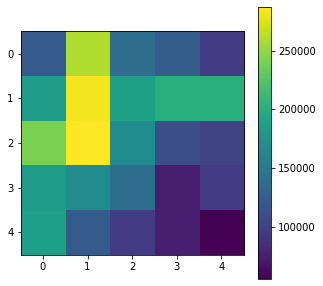

In [8]:
valids=np.zeros(CHANNELS)
for i in range(0,CHANNELS):
    valids[i]=count_nonzero(df["valid_tdc_%d"%i])
    
if CHANNELS==25:
    figure(figsize(5,5))
    valids=asarray(valids).reshape((5,5))
    imshow(valids)
    colorbar()
elif CHANNELS==49:
    figure(figsize(5,5))
    valids=asarray(valids).reshape((7,7))
    imshow(valids)
    colorbar()

print(valids)


#### Set some useful calculate some useful parameter

In [9]:
laser_MHz=laser_MHz*laser_factor
laser_Hz=laser_MHz*10**6
max_counter=2**16-1
sysclk_ps=1000000./sysclk_MHz #ps
print("SysClk ps:", sysclk_ps)
laser_ps=1000000./laser_MHz #ps
print("LaserClk ps:", laser_ps)
ratio=sysclk_MHz/laser_MHz
sysclk_ps=1e6/sysclk_MHz
laser_ps=1e6/laser_MHz
nbins=int(round(laser_ps/kC4))
print("actual kC4", laser_ps/nbins)

SysClk ps: 4166.666666666667
LaserClk ps: 12500.0
actual kC4 48.07692307692308


# Data frame conversion to H5 format

In [10]:
myReturn=ttp.convertFromPandasDataFrame( df, filenameOutputHDF5=filenameHDF5 ,
                    sysclk_MHz = sysclk_MHz,
                    laser_MHz = laser_MHz,
                    list_of_channels=list_of_channels,
                    compressionLevel=0,
                    ignorePixelLineFrame = False,
                    coincidence_analysis = False,
                    kC4=kC4
                        )

Calculate rates 
Calculate cumulative step 
Add cumulativeStep
Acquisition lasted:  55.4934385375 s
Scan_enable 8.0 ratio 9.529276378913093e-07 rate 0.14416118753560309
line_enable 6853.0 ratio 0.0008163016378086429 rate 123.49207727268599
pixel_enable 262144.0 ratio 0.031225532838422422 rate 4723.873793166642
Laser 4020910.0 ratio 0.47895453355919304 rate 72457.39507172273
Calculate totalphotons 
start the sum
sum done
kC4<=== 48
sysclk_ps<=== 4166.666666666667
kC4<=== 47.89272030651341
Start process
Start analysisForImg
Arrays copied into analysisForImg


Current frame: 1 	: : 8479051it [00:02, 3764238.26it/s]                         


Total Frame: 1
New HDF5 written
total_photon        uint8
cumulative_step     int64
arr_px             uint16
arr_px_corr        uint16
arr_py             uint16
arr_frame          uint16
dtype: object


  0%|                                                    | 0/25 [00:00<?, ?it/s]

Start conversion of 0 channel
t_0 valid_tdc_0
..
...



  0%|                                               | 0/4113713 [00:00<?, ?it/s]
4154837it [00:00, 40531050.59it/s]                                              
  4%|█▊                                          | 1/25 [00:01<00:37,  1.57s/it]

starting loop
Data ready, conversion to array
Adding keys to HDF5...  "ch_0"
t_0      int16
t_L      int16
dS_0    uint16
dtype: object
Start conversion of 1 channel
t_1 valid_tdc_1
..
...



  0%|                                               | 0/4205307 [00:00<?, ?it/s]
4247353it [00:00, 37037854.90it/s]                                              

starting loop
Data ready, conversion to array
Adding keys to HDF5...  "ch_1"



  8%|███▌                                        | 2/25 [00:03<00:36,  1.59s/it]

t_1      int16
t_L      int16
dS_1    uint16
dtype: object
Start conversion of 2 channel
t_2 valid_tdc_2
..
...



  0%|                                               | 0/4129594 [00:00<?, ?it/s]
4170795it [00:00, 34227317.85it/s]                                              

starting loop
Data ready, conversion to array
Adding keys to HDF5...  "ch_2"



 12%|█████▎                                      | 3/25 [00:04<00:34,  1.57s/it]

t_2      int16
t_L      int16
dS_2    uint16
dtype: object
Start conversion of 3 channel
t_3 valid_tdc_3
..
...



4153928it [00:00, 51380854.83it/s]                                              
 16%|███████                                     | 4/25 [00:06<00:32,  1.54s/it]

starting loop
Data ready, conversion to array
Adding keys to HDF5...  "ch_3"
t_3      int16
t_L      int16
dS_3    uint16
dtype: object
Start conversion of 4 channel
t_4 valid_tdc_4
..
...



4138677it [00:00, 57217862.29it/s]                                              
 20%|████████▊                                   | 5/25 [00:07<00:30,  1.50s/it]

starting loop
Data ready, conversion to array
Adding keys to HDF5...  "ch_4"
t_4      int16
t_L      int16
dS_4    uint16
dtype: object
Start conversion of 5 channel
t_5 valid_tdc_5
..
...



4194732it [00:00, 45475292.02it/s]                                              

starting loop
Data ready, conversion to array
Adding keys to HDF5...  "ch_5"



 24%|██████████▌                                 | 6/25 [00:09<00:29,  1.55s/it]

t_5      int16
t_L      int16
dS_5    uint16
dtype: object
Start conversion of 6 channel
t_6 valid_tdc_6
..
...



  0%|                                               | 0/4228839 [00:00<?, ?it/s]
4271088it [00:00, 25103158.50it/s]                                              

starting loop
Data ready, conversion to array


Adding keys to HDF5...  "ch_6"


 28%|████████████▎                               | 7/25 [00:10<00:28,  1.59s/it]

t_6      int16
t_L      int16
dS_6    uint16
dtype: object
Start conversion of 7 channel
t_7 valid_tdc_7
..
...



4190389it [00:00, 44949886.82it/s]                                              
 32%|██████████████                              | 8/25 [00:12<00:26,  1.57s/it]

starting loop
Data ready, conversion to array
Adding keys to HDF5...  "ch_7"
t_7      int16
t_L      int16
dS_7    uint16
dtype: object
Start conversion of 8 channel
t_8 valid_tdc_8
..
...



  0%|                                               | 0/4170319 [00:00<?, ?it/s]
4212003it [00:00, 34653426.97it/s]                                              

starting loop
Data ready, conversion to array
Adding keys to HDF5...  "ch_8"



 36%|███████████████▊                            | 9/25 [00:14<00:25,  1.58s/it]

t_8      int16
t_L      int16
dS_8    uint16
dtype: object
Start conversion of 9 channel
t_9 valid_tdc_9
..
...



  0%|                                               | 0/4162964 [00:00<?, ?it/s]
4204529it [00:00, 28679765.04it/s]                                              

starting loop
Data ready, conversion to array
Adding keys to HDF5...  "ch_9"



 40%|█████████████████▏                         | 10/25 [00:15<00:24,  1.60s/it]

t_9      int16
t_L      int16
dS_9    uint16
dtype: object
Start conversion of 10 channel
t_10 valid_tdc_10
..
...



  0%|                                               | 0/4214272 [00:00<?, ?it/s]
4256342it [00:00, 33447042.30it/s]                                              

starting loop
Data ready, conversion to array
Adding keys to HDF5...  "ch_10"



 44%|██████████████████▉                        | 11/25 [00:17<00:22,  1.61s/it]

t_10      int16
t_L       int16
dS_10    uint16
dtype: object
Start conversion of 11 channel
t_11 valid_tdc_11
..
...



  0%|                                               | 0/4223776 [00:00<?, ?it/s]
4265937it [00:00, 26514798.27it/s]                                              

starting loop
Data ready, conversion to array
Adding keys to HDF5...  "ch_11"



 48%|████████████████████▋                      | 12/25 [00:19<00:21,  1.64s/it]

t_11      int16
t_L       int16
dS_11    uint16
dtype: object
Start conversion of 12 channel
t_12 valid_tdc_12
..
...



4169078it [00:00, 46431620.75it/s]                                              
 52%|██████████████████████▎                    | 13/25 [00:20<00:19,  1.61s/it]

starting loop
Data ready, conversion to array
Adding keys to HDF5...  "ch_12"
t_12      int16
t_L       int16
dS_12    uint16
dtype: object
Start conversion of 13 channel
t_13 valid_tdc_13
..
...



4144131it [00:00, 41450836.87it/s]                                              
 56%|████████████████████████                   | 14/25 [00:22<00:17,  1.59s/it]

starting loop
Data ready, conversion to array
Adding keys to HDF5...  "ch_13"
t_13      int16
t_L       int16
dS_13    uint16
dtype: object
Start conversion of 14 channel
t_14 valid_tdc_14
..
...



4131708it [00:00, 53503880.55it/s]                                              
 60%|█████████████████████████▊                 | 15/25 [00:23<00:15,  1.56s/it]

starting loop
Data ready, conversion to array
Adding keys to HDF5...  "ch_14"
t_14      int16
t_L       int16
dS_14    uint16
dtype: object
Start conversion of 15 channel
t_15 valid_tdc_15
..
...



4198368it [00:00, 45124338.73it/s]                                              

starting loop
Data ready, conversion to array
Adding keys to HDF5...  "ch_15"



 64%|███████████████████████████▌               | 16/25 [00:25<00:13,  1.55s/it]

t_15      int16
t_L       int16
dS_15    uint16
dtype: object
Start conversion of 16 channel
t_16 valid_tdc_16
..
...



  0%|                                               | 0/4152150 [00:00<?, ?it/s]
4193621it [00:00, 32377294.40it/s]                                              

starting loop
Data ready, conversion to array
Adding keys to HDF5...  "ch_16"



 68%|█████████████████████████████▏             | 17/25 [00:26<00:12,  1.58s/it]

t_16      int16
t_L       int16
dS_16    uint16
dtype: object
Start conversion of 17 channel
t_17 valid_tdc_17
..
...



4168472it [00:00, 48051269.41it/s]                                              
 72%|██████████████████████████████▉            | 18/25 [00:28<00:10,  1.55s/it]

starting loop
Data ready, conversion to array
Adding keys to HDF5...  "ch_17"
t_17      int16
t_L       int16
dS_17    uint16
dtype: object
Start conversion of 18 channel
t_18 valid_tdc_18
..
...



4121911it [00:00, 46087923.08it/s]                                              
 76%|████████████████████████████████▋          | 19/25 [00:29<00:09,  1.54s/it]

starting loop
Data ready, conversion to array
Adding keys to HDF5...  "ch_18"
t_18      int16
t_L       int16
dS_18    uint16
dtype: object
Start conversion of 19 channel
t_19 valid_tdc_19
..
...



 80%|██████████████████████████████████▍        | 20/25 [00:31<00:07,  1.52s/it]

starting loop
Data ready, conversion to array
Adding keys to HDF5...  "ch_19"
t_19      int16
t_L       int16
dS_19    uint16
dtype: object
Start conversion of 20 channel
t_20 valid_tdc_20
..
...



4198065it [00:00, 44580840.48it/s]                                              

starting loop
Data ready, conversion to array
Adding keys to HDF5...  "ch_20"



 84%|████████████████████████████████████       | 21/25 [00:32<00:06,  1.55s/it]

t_20      int16
t_L       int16
dS_20    uint16
dtype: object
Start conversion of 21 channel
t_21 valid_tdc_21
..
...



4156150it [00:00, 51700620.06it/s]                                              
 88%|█████████████████████████████████████▊     | 22/25 [00:34<00:04,  1.52s/it]

starting loop
Data ready, conversion to array
Adding keys to HDF5...  "ch_21"
t_21      int16
t_L       int16
dS_21    uint16
dtype: object
Start conversion of 22 channel
t_22 valid_tdc_22
..
...



  0%|                                               | 0/4092028 [00:00<?, ?it/s]
4132920it [00:00, 36737315.81it/s]                                              

starting loop
Data ready, conversion to array
Adding keys to HDF5...  "ch_22"
t_22      int16
t_L       int16
dS_22    uint16
dtype: object



 92%|███████████████████████████████████████▌   | 23/25 [00:35<00:03,  1.52s/it]

Start conversion of 23 channel
t_23 valid_tdc_23
..
...



  0%|                                               | 0/4074721 [00:00<?, ?it/s]
4115447it [00:00, 38527324.70it/s]                                              
 96%|█████████████████████████████████████████▎ | 24/25 [00:37<00:01,  1.52s/it]

starting loop
Data ready, conversion to array
Adding keys to HDF5...  "ch_23"
t_23      int16
t_L       int16
dS_23    uint16
dtype: object
Start conversion of 24 channel
t_24 valid_tdc_24
..
...



4090298it [00:00, 65203993.97it/s]                                              
100%|███████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]

starting loop
Data ready, conversion to array
Adding keys to HDF5...  "ch_24"
t_24      int16
t_L       int16
dS_24    uint16
dtype: object
Data saved:  /YOURPATH/13_MEGA_512x512_200us_120FOV.h5


In [11]:
print("HDF5 is available:", filenameHDF5)

HDF5 is available: /YOURPATH/13_MEGA_512x512_200us_120FOV.h5


## Timing calibration of data

In [12]:
calibDict,list_of_channels_calibrated = ttp.calculateCalibFromH5(filenameH5=myReturn['filenameH5'],   # the HDF5 file input
                                                                 listChannel=list_of_channels,      # list of channel [0,mchannel]
                                                                 return_numeric_channels=True)        # to activate the list_of_channels_calibrated

  0%|                                                    | 0/25 [00:00<?, ?it/s]


ch_L calculated from ch_0


100%|███████████████████████████████████████████| 25/25 [00:18<00:00,  1.33it/s]


In [13]:
table_channels={}
for i in tqdm(list_of_channels_calibrated):
    table_channels[i] = ttp.applyCalibDict(myReturn['filenameH5'],
                        channel=i, 
                        calibDict=calibDict)

  0%|          | 0/25 [00:00<?, ?it/s]

# Creating 4D data matrix x-y-t-ch

In [14]:
image_4d=ttp.image_4d_fast(npixel,nbins,CHANNELS,table_channels, laser_ps)

100%|███████████████████████████████████████████| 25/25 [00:21<00:00,  1.18it/s]


### Create File

In [15]:
h5file = h5py.File(filenameHDF5, 'r+')
try:
    h5file.create_dataset("image_4d", data=image_4d)
except:
    del h5file["image_4d"]
    h5file.create_dataset("image_4d", data=image_4d)
h5file.close()

### Image

In [16]:
image_4d.shape
#x,y, time, ch

(512, 512, 260, 25)

In [17]:
image_4d[-1,-1,:,:]=0 # I REMOVE THE LAST PIXEL BECAUSE IN THIS PARTICULAR DATASET THE LAST PIXEL WAS ILLUMINATED MUCH LONGER THAN THE OTHERS

In [18]:
# 3D dataset
data_3d_channel_ch=image_4d[:,:,:,:].sum(axis=-1) #sum over all channels
# x-y image
image_channel_ch=data_3d_channel_ch.sum(axis=2) #sum over all time

Text(0, 0.5, 'Pixels')

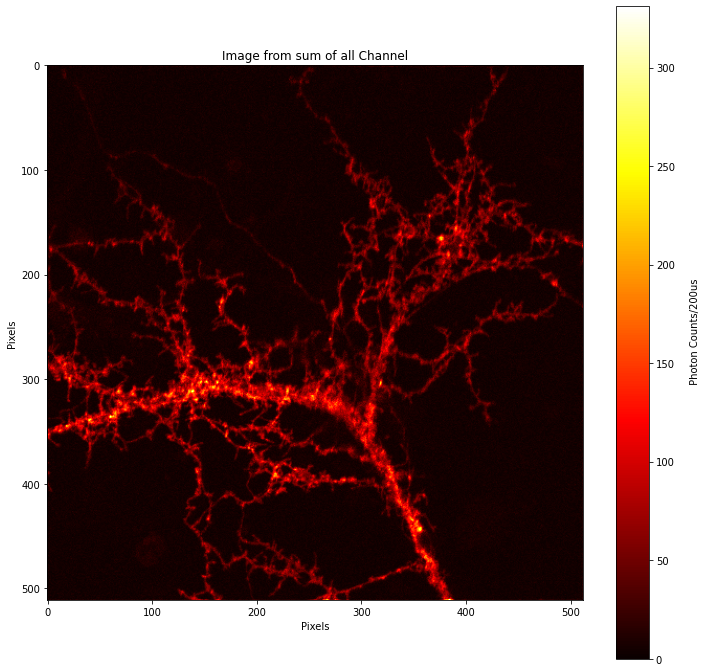

In [19]:
fig= plt.figure(figsize=(12,12))

plt.imshow(image_channel_ch,
           cmap='hot')

cbar = plt.colorbar()
cbar.set_label('\n Photon Counts/'+str(dwell_time)+'us')
title('Image from sum of all Channel')
xlabel('Pixels')
ylabel('Pixels')